# Purpose of This Notebook - External Validation

This notebook applies the finalized model to an external validation cohort.
It reproduces discrimination metrics, calibration curves, and Kaplan–Meier survival stratification.
Raw clinical data are not included here; users should place their external dataset inside the ./data/ directory.

## 1. Environment Setup and Load File

In [27]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, brier_score_loss,
    confusion_matrix, accuracy_score, precision_score, f1_score
)
from sklearn.calibration import calibration_curve
import warnings

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [129]:
df = pd.read_csv('./data/raw_data_EDA.csv')

## 2. EDA and Preprocessing

In [130]:
selected_cols = ['AJCC_Substage', 'LNR', 'Differentiation', 'PNI', 'edr_18m', 'DFS_Events', 'DFS_Months']
df_ext=df[selected_cols]
df_ext.info()

df_ext.isna().mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AJCC_Substage    142 non-null    object 
 1   LNR              141 non-null    float64
 2   Differentiation  135 non-null    float64
 3   PNI              140 non-null    float64
 4   edr_18m          142 non-null    int64  
 5   DFS_Events       142 non-null    int64  
 6   DFS_Months       142 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 7.9+ KB


AJCC_Substage      0.000000
LNR                0.007042
Differentiation    0.049296
PNI                0.014085
edr_18m            0.000000
DFS_Events         0.000000
DFS_Months         0.000000
dtype: float64

In [131]:
df_ext['AJCC_Substage'].value_counts(dropna=False)
df_ext['AJCC_Substage']=df_ext['AJCC_Substage'].astype('category')

In [132]:
df_ext['Differentiation'].astype('Int64')
df_ext['PNI'].astype('Int64')
print(df_ext.columns)
df_ext.to_parquet('EDA_Ext_Val.parquet')

Index(['AJCC_Substage', 'LNR', 'Differentiation', 'PNI', 'edr_18m',
       'DFS_Events', 'DFS_Months'],
      dtype='object')


## 3. Load external validation parquet

In [24]:
df_ext = pd.read_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/local_data/EDa_Ext_Val.parquet', engine='pyarrow') 
print(df_ext.columns)
feature_cols = ['AJCC_Substage', 'LNR', 'Differentiation', 'PNI']
# Prepare X_test (features) and y_test (outcome)
try:
    # Get model-required features and ascertain the order
    X_external = df_ext[feature_cols].copy()
    y_external = df_ext['edr_18m']
    
    print(f"Sample size: {len(X_external)}")
    print(f"EDR-18 event counts: {y_external.sum()}")

except KeyError as e:
    print(f"Error：can't find column {e}")

Index(['AJCC_Substage', 'LNR', 'Differentiation', 'PNI', 'edr_18m',
       'DFS_Events', 'DFS_Months'],
      dtype='object')
Sample size: 142
EDR-18 event counts: 19


## 4. Use the pre-built model to predict external cohort

In [25]:
# 1. Load Model & Features
# Load pre-saved models, columns
with open('/Users/huangshifeng/Desktop/stage_III_colon_surv/model/final_model_calibrated.pkl', 'rb') as f:
    model_pipeline = joblib.load(f)

with open('/Users/huangshifeng/Desktop/stage_III_colon_surv/model/final_feature_columns.pkl', 'rb') as f:
    features = joblib.load(f)

print("The model was loaded successfully")

# 2. Data Preprocessing (One-Hot Encoding)
# Build a dictionary for mapping (Fixed redundant keys for clarity)
mapping_3a = {'3A': 1} 
mapping_3b = {'3B': 1}
mapping_3c = {'3C': 1}

# Build columns manually
X_external['AJCC_Substage_3A'] = X_external['AJCC_Substage'].map(mapping_3a).fillna(0).astype(int)
X_external['AJCC_Substage_3B'] = X_external['AJCC_Substage'].map(mapping_3b).fillna(0).astype(int)
X_external['AJCC_Substage_3C'] = X_external['AJCC_Substage'].map(mapping_3c).fillna(0).astype(int)

# Remove 'AJCC_Substage' column
if 'AJCC_Substage' in X_external.columns:
    X_external = X_external.drop(columns=['AJCC_Substage'])

# Reindex to ensure columns match the training phase
X_external = X_external.reindex(columns=features)

# 3. Prediction & AUC Calculation
# Model prediction
y_pred_proba = model_pipeline.predict_proba(X_external)[:, 1]

print("Prediction completed")

# Calculate External AUC (point estimate)
# Note: Since this is a fixed, pre-trained model applied to external data, 
# this is the "External Validation AUC", not OOF CV AUC.
y_true_arr = np.array(y_external)      # Transform into numpy arrays for further use
y_prob_arr = y_pred_proba

ext_auc_pt = roc_auc_score(y_true_arr, y_prob_arr)
print(f"External Validation AUC (point estimate): {ext_auc_pt:.3f}")

# 4. Bootstrap Analysis for Metrics (Fixed Cutoff)
cutoff = 0.120
n_boots = 1000
random_seed = 8251

print(f"Cutoff value: pre-specified: {cutoff:.3f}")

# Function to calculate metrics
def calculate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    sen = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    return sen, spec, ppv, npv

# 1. Point Estimates for classification metrics
sen_pt, spec_pt, ppv_pt, npv_pt = calculate_metrics(y_true_arr, y_prob_arr, cutoff)

# 2. Bootstrap Loop (metrics + AUC)
boot_results = {
    'AUC': [],
    'Sen': [],
    'Spec': [],
    'PPV': [],
    'NPV': []
}

np.random.seed(random_seed)

for _ in range(n_boots):
    # Resample indices with replacement
    indices = np.random.choice(len(y_true_arr), len(y_true_arr), replace=True)
    
    y_true_boot = y_true_arr[indices]
    y_prob_boot = y_prob_arr[indices]
    
    # ---- AUC----
    if len(np.unique(y_true_boot)) == 2:
        auc_b = roc_auc_score(y_true_boot, y_prob_boot)
        boot_results['AUC'].append(auc_b)
    
    # ---- Other metrics ----
    s, sp, p, n = calculate_metrics(y_true_boot, y_prob_boot, cutoff)
    boot_results['Sen'].append(s)
    boot_results['Spec'].append(sp)
    boot_results['PPV'].append(p)
    boot_results['NPV'].append(n)

# 3. Output Results with 95% CI
print("-" * 40)
print(f"=== External Validation Performance (Bootstrap n={n_boots}) ===")

# AUC 95% CI
auc_lower = np.percentile(boot_results['AUC'], 2.5)
auc_upper = np.percentile(boot_results['AUC'], 97.5)
print(f"AUC: {ext_auc_pt:.3f} [{auc_lower:.3f} - {auc_upper:.3f}]")

metrics_map = {
    'Sensitivity': (sen_pt, boot_results['Sen']),
    'Specificity': (spec_pt, boot_results['Spec']),
    'PPV        ': (ppv_pt, boot_results['PPV']),
    'NPV        ': (npv_pt, boot_results['NPV'])
}

for name, (point_est, boots) in metrics_map.items():
    lower = np.percentile(boots, 2.5)
    upper = np.percentile(boots, 97.5)
    print(f"{name}: {point_est:.3f} [{lower:.3f} - {upper:.3f}]")

The model was loaded successfully
Prediction completed
External Validation AUC (point estimate): 0.637
Cutoff value: pre-specified: 0.120
----------------------------------------
=== External Validation Performance (Bootstrap n=1000) ===
AUC: 0.637 [0.503 - 0.761]
Sensitivity: 0.684 [0.474 - 0.895]
Specificity: 0.480 [0.393 - 0.560]
PPV        : 0.169 [0.086 - 0.257]
NPV        : 0.908 [0.830 - 0.971]


## 5. Build Conventional Logistic Model Using Only AJCC Substaging

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score

warnings.filterwarnings("ignore")

# Benchmark Analysis: AJCC Model on External Cohort

# 1. Define Variables
# Select only AJCC-related features from the External Validation set
features_ajcc = [col for col in X_external.columns if 'AJCC' in col]
X_ext_ajcc = X_external[features_ajcc]
y_ext = y_external.astype(int)

# 2. Initialize Conventional Logistic Regression
# C=1e9 simulates no regularization; class_weight='balanced' handles data imbalance
lr = LogisticRegression(C=1e9, class_weight='balanced', solver='liblinear', random_state=8251)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)

# 3. Calculate CV AUC
# We use Cross-Validation to evaluate the discriminative power of AJCC within this cohort
ajcc_scores = cross_val_score(lr, X_ext_ajcc, y_ext, cv=cv, scoring='roc_auc')

# 4. Generate Out-of-Fold (OOF) Predictions
# method='predict_proba' returns probabilities. We take column 1 (positive class).
y_prob_ext_cv = cross_val_predict(lr, X_ext_ajcc, y_ext, cv=cv, method='predict_proba')[:, 1]

# 5. Determine Optimal Cutoff (Youden's Index)
fpr, tpr, thresholds = roc_curve(y_ext, y_prob_ext_cv)
J = tpr - fpr
ix = np.argmax(J)
best_cutoff = thresholds[ix]

# Bootstrap Analysis for Performance Metrics + AUC

# Settings
n_boots = 1000
random_seed = 8251

# Convert to numpy arrays for efficient indexing
y_true_arr = np.array(y_ext)
y_prob_arr = y_prob_ext_cv

# Metric Calculation Function
def calculate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    # confusion_matrix returns [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # Calculate metrics with division-by-zero protection
    sen = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    return sen, spec, ppv, npv

# 1. Point Estimates (using the optimal cutoff found above)
sen_pt, spec_pt, ppv_pt, npv_pt = calculate_metrics(y_true_arr, y_prob_arr, best_cutoff)

# AUC point estimate（calculate using the whole external OOF predicted probabilities）
auc_pt = roc_auc_score(y_true_arr, y_prob_arr)

# 2. Execute Bootstrap
boot_results = {
    'AUC': [],
    'Sen': [],
    'Spec': [],
    'PPV': [],
    'NPV': []
}

np.random.seed(random_seed)

for _ in range(n_boots):
    # Resample indices with replacement
    indices = np.random.choice(len(y_true_arr), len(y_true_arr), replace=True)
    
    # Retrieve resampled data
    y_true_boot = y_true_arr[indices]
    y_prob_boot = y_prob_arr[indices]
    
    # ---- AUC----
    if len(np.unique(y_true_boot)) == 2:
        auc_b = roc_auc_score(y_true_boot, y_prob_boot)
        boot_results['AUC'].append(auc_b)
    
    # ---- Other metrics ----
    s, sp, p, n = calculate_metrics(y_true_boot, y_prob_boot, best_cutoff)
    boot_results['Sen'].append(s)
    boot_results['Spec'].append(sp)
    boot_results['PPV'].append(p)
    boot_results['NPV'].append(n)

# Output Results

print(f"AJCC Benchmark Model (External Cohort)")
print(f"Mean AUC (5-Fold CV)   : {ajcc_scores.mean():.3f}")
print(f"AUC (OOF, point estimate): {auc_pt:.3f}")
print(f"Optimal Cutoff (Youden): {best_cutoff:.4f}")

# AUC 95% CI
auc_lower = np.percentile(boot_results['AUC'], 2.5)
auc_upper = np.percentile(boot_results['AUC'], 97.5)
print(f"AUC 95% CI (bootstrap): [{auc_lower:.3f} - {auc_upper:.3f}]")

metrics_map = {
    'Sensitivity': (sen_pt, boot_results['Sen']),
    'Specificity': (spec_pt, boot_results['Spec']),
    'PPV        ': (ppv_pt, boot_results['PPV']),
    'NPV        ': (npv_pt, boot_results['NPV'])
}

for name, (point_est, boots) in metrics_map.items():
    lower = np.percentile(boots, 2.5)
    upper = np.percentile(boots, 97.5)
    print(f"{name}: {point_est:.3f} [{lower:.3f} - {upper:.3f}]")

AJCC Benchmark Model (External Cohort)
Mean AUC (5-Fold CV)   : 0.617
AUC (OOF, point estimate): 0.550
Optimal Cutoff (Youden): 0.6106
AUC 95% CI (bootstrap): [0.405 - 0.696]
Sensitivity: 0.421 [0.200 - 0.667]
Specificity: 0.764 [0.689 - 0.839]
PPV        : 0.216 [0.088 - 0.351]
NPV        : 0.895 [0.833 - 0.951]


External Validation AUC: 0.637
Brier Score: 0.128
External Validation Results (Cutoff = 0.12)
Confusion Matrix:
[[59 64]
 [ 6 13]]
TP (True Positive): 13
FN (False Negative): 6
FP (False Positive): 64
TN (True Negative): 59


Sensitivity (Recall) : 0.684
Specificity          : 0.480
Accuracy             : 0.507
Precision            : 0.169
F1 Score             : 0.271

=== 95% CI (Bootstrap, External Cohort) ===
AUC      : 0.637 (95% CI 0.503–0.761)
Sens     : 0.684 (95% CI 0.474–0.895)
Spec     : 0.480 (95% CI 0.393–0.560)
PPV      : 0.169 (95% CI 0.086–0.257)
NPV      : 0.908 (95% CI 0.830–0.971)


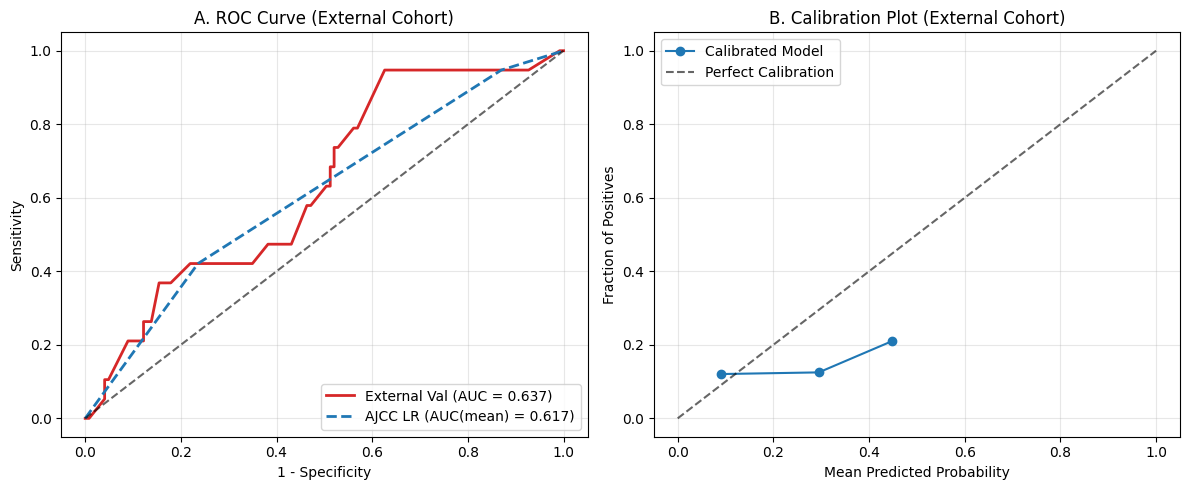

In [13]:
# Point estimates

# AUC
auc = roc_auc_score(y_external, y_pred_proba)
print(f"External Validation AUC: {auc:.3f}")

# Brier Score
brier = brier_score_loss(y_external, y_pred_proba)
print(f"Brier Score: {brier:.3f}")

# Set cutoff Value（OOF-derived 0.12）
custom_cutoff = 0.120

# Using cutoff value to classify
y_pred_custom = (y_pred_proba >= custom_cutoff).astype(int)

# Confusion matrix and performance metrics
cm_custom = confusion_matrix(y_external, y_pred_custom)
tn, fp, fn, tp = cm_custom.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
accuracy = accuracy_score(y_external, y_pred_custom)
precision = precision_score(y_external, y_pred_custom, zero_division=0)
f1 = f1_score(y_external, y_pred_custom, zero_division=0)

print(f"External Validation Results (Cutoff = {custom_cutoff})")
print(f"Confusion Matrix:\n{cm_custom}")
print(f"TP (True Positive): {tp}")
print(f"FN (False Negative): {fn}")
print(f"FP (False Positive): {fp}")
print(f"TN (True Negative): {tn}")
print(f"\n")

print(f"Sensitivity (Recall) : {sensitivity:.3f}")
print(f"Specificity          : {specificity:.3f}")
print(f"Accuracy             : {accuracy:.3f}")
print(f"Precision            : {precision:.3f}")
print(f"F1 Score             : {f1:.3f}")

# 1. Bootstrap for 95% CI Estimation

n_bootstraps = 1000
rng = np.random.RandomState(8251)

boot_auc = []
boot_sens = []
boot_spec = []
boot_ppv = []
boot_npv = []

y = np.array(y_external)
p = np.array(y_pred_proba)

for i in range(n_bootstraps):
    indices = rng.randint(0, len(y), len(y))
    y_boot = y[indices]
    p_boot = p[indices]

    # Avoid all 0 or all 1
    if y_boot.sum() == 0 or y_boot.sum() == len(y_boot):
        continue

    # AUC
    try:
        boot_auc.append(roc_auc_score(y_boot, p_boot))
    except ValueError:
        continue

    y_pred_boot = (p_boot >= custom_cutoff).astype(int)
    cm = confusion_matrix(y_boot, y_pred_boot)
    tn_b, fp_b, fn_b, tp_b = cm.ravel()

    sens_b = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
    spec_b = tn_b / (tn_b + fp_b) if (tn_b + fp_b) > 0 else 0
    ppv_b  = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
    npv_b  = tn_b / (tn_b + fn_b) if (tn_b + fn_b) > 0 else 0

    boot_sens.append(sens_b)
    boot_spec.append(spec_b)
    boot_ppv.append(ppv_b)
    boot_npv.append(npv_b)

# 轉成 array
boot_auc  = np.array(boot_auc)
boot_sens = np.array(boot_sens)
boot_spec = np.array(boot_spec)
boot_ppv  = np.array(boot_ppv)
boot_npv  = np.array(boot_npv)

def ci_95(arr):
    return np.percentile(arr, [2.5, 97.5])

auc_ci   = ci_95(boot_auc)
sens_ci  = ci_95(boot_sens)
spec_ci  = ci_95(boot_spec)
ppv_ci   = ci_95(boot_ppv)
npv_ci   = ci_95(boot_npv)

print("\n=== 95% CI (Bootstrap, External Cohort) ===")
print(f"AUC      : {auc:.3f} (95% CI {auc_ci[0]:.3f}–{auc_ci[1]:.3f})")
print(f"Sens     : {sensitivity:.3f} (95% CI {sens_ci[0]:.3f}–{sens_ci[1]:.3f})")
print(f"Spec     : {specificity:.3f} (95% CI {spec_ci[0]:.3f}–{spec_ci[1]:.3f})")
print(f"PPV      : {precision:.3f} (95% CI {ppv_ci[0]:.3f}–{ppv_ci[1]:.3f})")
print(f"NPV      : { (tn / (tn + fn)) if (tn + fn) > 0 else 0:.3f} (95% CI {npv_ci[0]:.3f}–{npv_ci[1]:.3f})")

# Visualization (ROC + Calibration)

plt.figure(figsize=(12, 5))

# Plot A: ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_external, y_pred_proba)
fpr_ajcc, tpr_ajcc, _ = roc_curve(y, y_prob_ext_ajcc)
plt.plot(fpr, tpr, label=f"External Val (AUC = {auc:.3f})", color='#d62728', lw=2)
plt.plot(fpr_ajcc, tpr_ajcc, color='#1f77b4', lw=2, linestyle='--', label=f'AJCC LR (AUC(mean) = {ajcc_scores.mean():.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('A. ROC Curve (External Cohort)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot B: Calibration Plot (Reliability Curve)
plt.subplot(1, 2, 2)
prob_true, prob_pred = calibration_curve(y_external, y_pred_proba, n_bins=5)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model', color='#1f77b4')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', alpha=0.6)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('B. Calibration Plot (External Cohort)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figure_S3_External_Calibration_Performance.tiff', format='tiff', dpi=600)
plt.savefig('Figure_S3_External_Calibration_Performance.png', dpi=300)
plt.show()      

IIIB Risks Stratified: Risk_Group
Low Risk     49
High Risk    39
Name: count, dtype: int64


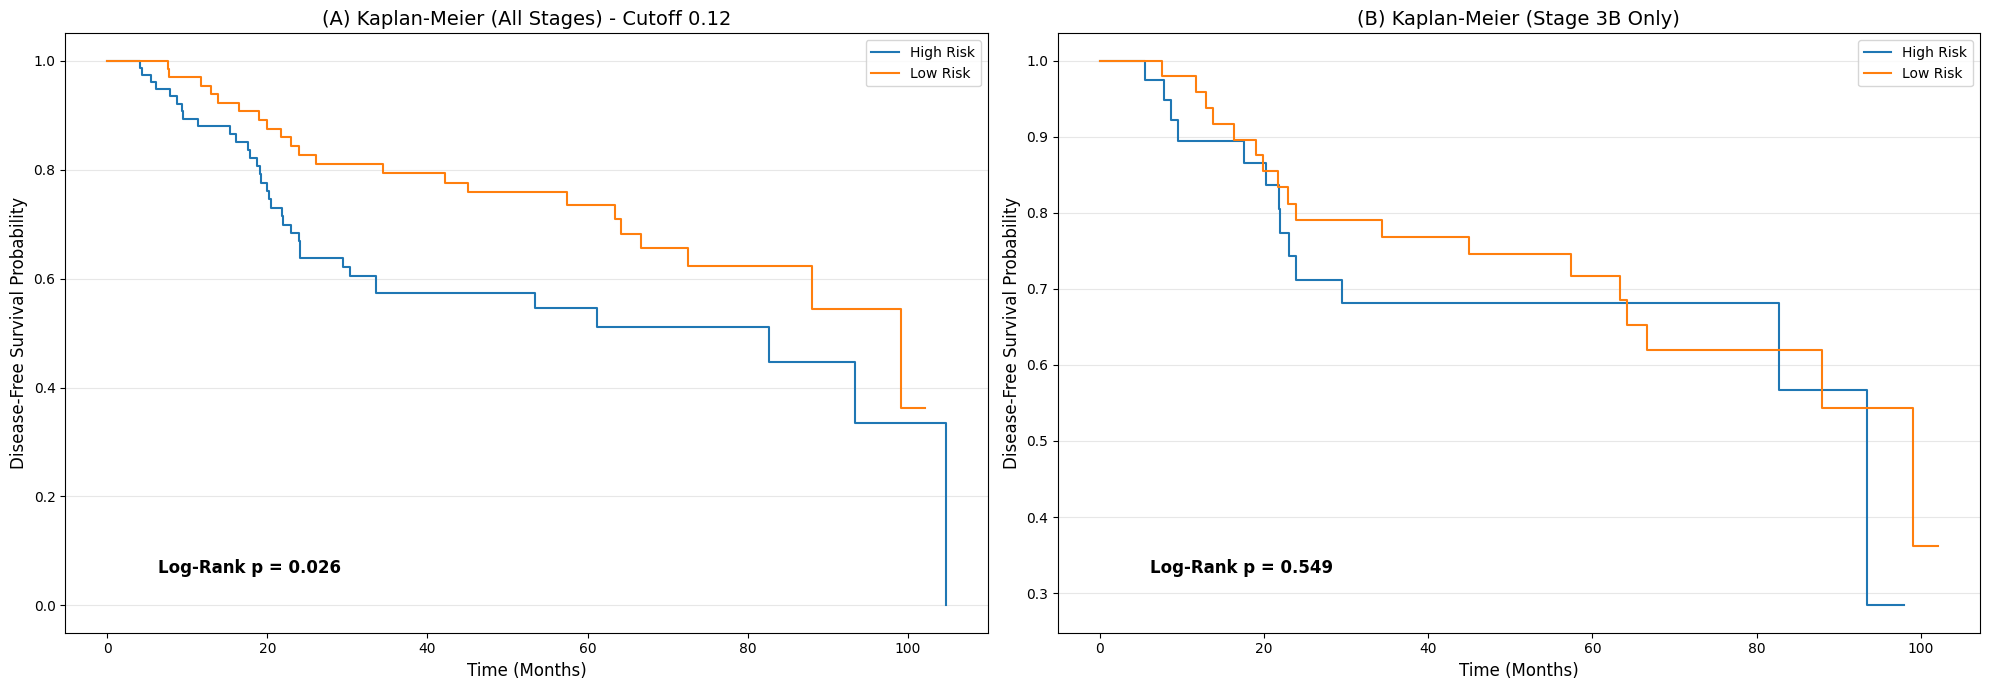

=== Cox regression: External cohort, all stage III ===
HR (High vs Low) = 1.84 [1.07–3.17], p = 0.029

=== Cox regression: External cohort, Stage 3B only ===
HR (High vs Low) = 1.25 [0.60–2.58], p = 0.549


In [29]:
# 1. Risk Stratification
cutoff = 0.120

df_ext['Predicted_Prob'] = y_pred_proba
df_ext['Risk_Group'] = df_ext['Predicted_Prob'].apply(lambda x: 'High Risk' if x >= cutoff else 'Low Risk')

def plot_km_on_ax(data, title, ax, time_col='DFS_Months', event_col='DFS_Events'):
    kmf = KaplanMeierFitter()
    
    # Ensure consistent group order (optional)
    groups = sorted(data['Risk_Group'].unique())
    
    for group in groups:
        mask = (data['Risk_Group'] == group)
        # Key step: Pass ax=ax to specify which subplot to draw on
        kmf.fit(data[time_col][mask], data[event_col][mask], label=group)
        kmf.plot_survival_function(ax=ax, ci_show=False) 

    high_risk = data[data['Risk_Group'] == 'High Risk']
    low_risk = data[data['Risk_Group'] == 'Low Risk']
    
    # Log-rank test
    if len(high_risk) > 0 and len(low_risk) > 0:
        results = logrank_test(high_risk[time_col], low_risk[time_col], 
                               event_observed_A=high_risk[event_col], 
                               event_observed_B=low_risk[event_col])
        p_value = results.p_value
        # Use ax.text and ax.transAxes for positioning text relative to the axes
        ax.text(0.1, 0.1, f'Log-Rank p = {p_value:.3f}', transform=ax.transAxes, fontsize=12, fontweight='bold')
    else:
        ax.text(0.1, 0.1, 'Groups not balanced', transform=ax.transAxes)

    # Set titles and labels (Note: syntax changes from plt.title to ax.set_title, etc.)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Time (Months)', fontsize=12)
    ax.set_ylabel('Disease-Free Survival Probability', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(loc="upper right") # Ensure legend is displayed

# --- Main Execution Block ---

# 1. Setup Canvas: 1 Row, 2 Columns (adjust figsize for width/height)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 2. Left Panel (axes[0]): All Patients (All Stages)
plot_km_on_ax(df_ext, title=f'(A) Kaplan-Meier (All Stages) - Cutoff {cutoff}', ax=axes[0])

# 3. Right Panel (axes[1]): Stage IIIB Subgroup Only
target_substage = '3B'
df_iiib = df_ext[df_ext['AJCC_Substage'] == target_substage].copy()

if len(df_iiib) > 0:
    print("IIIB Risks Stratified:", df_iiib['Risk_Group'].value_counts())
    plot_km_on_ax(df_iiib, title=f'(B) Kaplan-Meier (Stage {target_substage} Only)', ax=axes[1])
else:
    # Handle empty data case
    axes[1].text(0.5, 0.5, f"No data for {target_substage}", ha='center')

# 4. Adjust layout and display
plt.tight_layout()
plt.savefig('Figure_S4_KM_Risk_Stratified_External.tiff', format='tiff', dpi=600)
plt.savefig('Figure_S4_KM_Risk_Stratified_External.png', dpi=300)
plt.show()

# ============================
# 1) Cox: all Stage III patients
# ============================
cox_all = df_ext[['DFS_Months', 'DFS_Events', 'Risk_Group']].copy()

# Grouped by High / Low  Risk Group
cox_all = cox_all[cox_all['Risk_Group'].isin(['High Risk', 'Low Risk'])]

# Build binary variable：High Risk = 1, Low Risk = 0
cox_all['Risk_High'] = (cox_all['Risk_Group'] == 'High Risk').astype(int)

cph_all = CoxPHFitter()
cph_all.fit(cox_all[['DFS_Months', 'DFS_Events', 'Risk_High']],
            duration_col='DFS_Months',
            event_col='DFS_Events')

summary_all = cph_all.summary.loc['Risk_High']
hr_all      = summary_all['exp(coef)']
hr_all_low  = summary_all['exp(coef) lower 95%']
hr_all_high = summary_all['exp(coef) upper 95%']
p_all       = summary_all['p']

print("=== Cox regression: External cohort, all stage III ===")
print(f"HR (High vs Low) = {hr_all:.2f} "
      f"[{hr_all_low:.2f}–{hr_all_high:.2f}], p = {p_all:.3f}")
print()

# ============================
# 2) Cox: Stage IIIB subgroup
# ============================
target_substage = '3B'
df_iiib = df_ext[df_ext['AJCC_Substage'] == target_substage].copy()

cox_iiib = df_iiib[['DFS_Months', 'DFS_Events', 'Risk_Group']].copy()
cox_iiib = cox_iiib[cox_iiib['Risk_Group'].isin(['High Risk', 'Low Risk'])]

if len(cox_iiib['Risk_Group'].unique()) == 2 and cox_iiib['DFS_Events'].sum() > 0:
    cox_iiib['Risk_High'] = (cox_iiib['Risk_Group'] == 'High Risk').astype(int)

    cph_iiib = CoxPHFitter()
    cph_iiib.fit(cox_iiib[['DFS_Months', 'DFS_Events', 'Risk_High']],
                 duration_col='DFS_Months',
                 event_col='DFS_Events')

    summary_iiib = cph_iiib.summary.loc['Risk_High']
    hr_iiib      = summary_iiib['exp(coef)']
    hr_iiib_low  = summary_iiib['exp(coef) lower 95%']
    hr_iiib_high = summary_iiib['exp(coef) upper 95%']
    p_iiib       = summary_iiib['p']

    print(f"=== Cox regression: External cohort, Stage {target_substage} only ===")
    print(f"HR (High vs Low) = {hr_iiib:.2f} "
          f"[{hr_iiib_low:.2f}–{hr_iiib_high:.2f}], p = {p_iiib:.3f}")
else:
    print(f"Stage {target_substage}: can't run Cox analysis")

In [ ]:
df_ext['AJCC_Substage'].value_counts()
IIIB_ratio=len(df_ext[df_ext['AJCC_Substage']=='3B'])/len(df_ext)
IIIB_counts=len(df_ext[df_ext['AJCC_Substage']=='3B'])
IIIB_event_counts=len(df_ext[(df_ext['AJCC_Substage']=='3B') & (df_ext['DFS_Events']==1)])

print(f'IIIB ratio：{IIIB_ratio:.3f}')
print(f'IIIB counts：{IIIB_counts}')
print(f'IIIB DFS Event Counts：{IIIB_event_counts}')
print(f'IIIB DFS Event Ratio：{(IIIB_event_counts/IIIB_counts):.2%}')